# Report on ATP and WTA Tennis Matches 2015-2023

## Stage I: Business Understanding

In this report we aim to understand tennis analytics with a focus on ATP and WTA tournaments from 2015 to 2023. The report will be focused on relationships between players performance and various variables such as surface, ranking etc. Our objective it to gain insight into player performance, surface preferences, and various match-related metrics. By doing this report we aim to provide valuable information that can benefit stakeholders or investors involved in tennis, such as players, coaches, tournament organizers, and potentially fans.

ATP and WTA refer to two main professional tennis organizations that govern men's and women's tennis.
- **ATP (Association of Tennis Professionals)** is the governing body for men's professional tennis. It organizes the majority of the men's tennis tournaments around the world. These tournaments are categorized into different levels, including Grand Slams (such as Australian Open, Wimbledon, Roland Garros), ATP Tour Masters 1000, ATP Tour 500, and ATP Tour 250. These tournaments further offer ranking points, and a player's ATP ranking is a crucial factor in determining the player's eligibility and seeding in tournaments.
- **WTA (Women's Tennis Association)** is on the other hand, the governing body for women's professional tennis. It is responsible for organizing and managing women's tennis tournaments globally. WTA tournaments also include Grand Slams etc. Similarly to ATP, players earn ranking points based on their performance in these tournaments. 

Both ATP and WTA are attracting top tennis players from all around the world to showcase their skills on different surfaces like clay, grass, and hard court. The results of these tournaments influence players' standings, tournament seedings, and their overall careers in professional tennis.


Key aspects of this report include:

1. **Player-Surface Relationship:** Understand how players perform on different surfaces and identify any patterns or preferences.

2. **Match Outcome Prediction:** Building a model to predict future match results and other match-related features (duration, number of games, number of aces etc.).

3. **"Favourite" opponents:** Investigating the dynamics of player matchups, especially those with a highly unbalanced long-term score.

4. **Quality of Play Metrics:** Examining individual metrics like the share of double faults to identify unique player characteristics and playing styles.

5. **Ranking Impact on Match Results:** Analyzing the correlation between player rankings and match outcomes, with a potential focus on how this correlation varies across different surfaces.

The insights from this report could be valuable for making informed decisions in the tennis domain, such as strategic planning for players, optimizing training regimes etc.

In [170]:
import pandas as pd
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import glob

pd.set_option("display.precision", 2)

In [171]:
list_of_csvs = glob.glob('tennis/*.csv')

In [172]:
dataframes = []
df_w = pd.DataFrame()
df_m = pd.DataFrame()

for csv_file in list_of_csvs:
    df = pd.read_csv(csv_file)
    dataframes.append(df)

    file_name = csv_file.split('/')[-1]  # Extract the file name from the path
    if file_name.startswith('w'):
        df_w = pd.concat([df_w, df], ignore_index=True)
    elif file_name.startswith('a'):
        df_m = pd.concat([df_m, df], ignore_index=True)

In [173]:
# check if all dataframes have the same columns - if yes I want to concatenate them 
# to one dataframe containing all information
first_df_columns = dataframes[0].columns

for df in dataframes[1:]:
    if not df.columns.equals(first_df_columns):
        print(f"The columns of {df} are not the same as the columns of the first DataFrame.")

In [174]:
# since all dataframes have the same columns I will concatenate all of them and explore the data as a whole
merged_df = pd.concat(dataframes, ignore_index=True)

In [175]:
sh_df = merged_df.shape

## Stage II: Data Understanding

Data come from 18 different datasets - 9 from ATP tournaments and 9 from WTA tournaments. Each dataset contains matches that took place in the given year (2015-2023). These datasets have been aquired from <a href="https://gitlab.mff.cuni.cz/mlyni8am/ndbi048/-/tree/master/data?ref_type=heads"> GitLab repository of the NDBI048 class</a>. 

I concatenated all datasets in one since all of them contain the same columns and it is more handy to work with one dataset than 19 datasets. I also created a separate dataframes for WTA and ATP tournaments since I want to distinguish some statistics between male and female players.

#### Size of the dataset

In [176]:
print("The number of rows in the merged dataset is: ", merged_df.shape[0])
print("The number of columns in the merged dataset is: ", merged_df.shape[1])

The number of rows in the merged dataset is:  46658
The number of columns in the merged dataset is:  49


In [177]:
print("The number of rows in the WTA dataset is: ", df_w.shape[0])
#print("The number of columns in the WTA dataset is: ", df_w.shape[1])
print("The number of rows in the ATP dataset is: ", df_m.shape[0])
#print("The number of columns in the ATP dataset is: ", df_m.shape[1])

The number of rows in the WTA dataset is:  22679
The number of rows in the ATP dataset is:  23979


In [178]:
print("The list of all columns in the merged dataset is: ", list(merged_df.columns))

The list of all columns in the merged dataset is:  ['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points']


#### Columns Description:
- `tourney_id` = unique identifier for tournaments
- `tourney_name` = name of the tournament (e. g. Wibledon, Roland Garros)
- `surface` = what surface was the match played on
- `draw_size` = Number of players in the draw - this number is often rounded up to the nearest power of 2
- `tourney_level` = For men: 'G' = Grand Slams, 'M' = Masters 1000s, 'A' = other tour-level events, 'C' = Challengers, 'S' = Satellites/ITFs, 'F' = Tour finals and other season-ending events, and 'D' = Davis cup. For women there are several additional tourney_level codes, including 'P' = Premier, 'PM' = Premier Mandatory, and 'I' = International. (The various levels of ITFs are given by the prize money (in thousands), such as '15' = ITF $15,000. Other codes, such as 'T1' for Tier I 
(and so on) are used for older WTA tournament designations. 'D' is used for Federation/Fed/Billie Jean King Cup, and also for Wightman Cup 
and Bonne Bell Cup). For both 'E' = exhibition, 'J' = juniors
- `tourney_date` = eight digits in the YYYYMMDD format, usually the Monday of the tournament week
- `match_num` = a match-specific identifier. Often starting from 1, sometimes counting down from 300, and sometimes arbitrary
- `winner_id` = the player_id used in this repo for the winner of the match
- `winner_seed` = the seeding of the player who won the match
- `winner_entry` = 'WC' = wild card, 'Q' = qualifier, 'LL' = lucky loser, 'PR' = protected ranking, 'ITF' = ITF entry, and there are a few others that are occasionally used
- `winner_name`
- `winner_hand` = R = right, L = left, U = unknown. For ambidextrous players, this is their serving hand
- `winner_ht` = height in centimeters
- `winner_ioc` = three-character country code
- `winner_age` - age in years as of the `tourney_date`
- `loser_id` = same as for winner
- `loser_seed` = same as for winner
- `loser_entry` = same as for winner
- `loser_name` = same as for winner
- `loser_hand` = same as for winner
- `loser_ht` = same as for winner
- `loser_ioc` = same as for winner
- `loser_age` = same as for winner
- `score`
- `best_of` = '3' or '5', indicating the number of sets for this match
- `round`
- `minutes` = match length
- `w_ace` = winner's number of aces
- `w_df` = winner's number of double faults
- `w_svpt` = winner's number of serve points
- `w_1stIn` = winner's number of first serves made
- `w_1stWon` = winner's number of first-serve points won
- `w_2ndWon` = winner's number of second-serve points won
- `w_SvGms` = winner's number of serve games
- `w_bpSaved` = winner's number of break points saved
- `w_bpFaced` = winner's number of break points faced
- `l_ace` = same as for winner
- `l_df` = same as for winner
- `l_svpt` = same as for winner
- `l_1stIn` = same as for winner
- `l_1stWon` = same as for winner
- `l_2ndWon` = same as for winner
- `l_SvGms` = same as for winner
- `l_bpSaved` = same as for winner
- `l_bpFaced` = same as for winner
- `winner_rank` = winner's ATP or WTA rank, as of the tourney_date or the most recent ranking date before the tourney_date
- `winner_rank_points` = number of ranking points, where available
- `loser_rank` = same as for winner
- `loser_rank_points` = same as for winner

#### Categories of the variables:
**Numeric:**
- draw_size
- match_num
- winner_id
- winner_ht (float)
- winner age
- loser_id, loser_ht, loser_age, best_of
- minutes
- w_ace
- w_df
- w_svpt
- w_1stIn
- w_1stWon
- w_2ndWon
- w_SvGms
- w_bpSaved          
- w_bpFaced           
- l_ace               
- l_df                
- l_svpt              
- l_1stIn             
- l_1stWon            
- l_2ndWon            
- l_SvGms             
- l_bpSaved           
- l_bpFaced           
- winner_rank         
- winner_rank_points  
- loser_rank          
- loser_rank_points

**Oridnal:**
- tourney_level
- round

**Nominal:** 
- tourney_id
- tourney_name
- surface
- winner_hand
- winner_ioc
- loser_hand
- loser_ioc
- score

**Binary:**
- winner_entry
- loser_entry

#### Data quality

We need to check for duplicated rows in the dataset as we want to use row as a statistical unit for our goal. The goal is to predict future matches outcome and for that we need the rows of this dataset. Further in this report we will consider removing some columns.

In [179]:
sum(df.duplicated(subset=['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level', 'tourney_date', 'match_num', 'winner_id', 'winner_seed', 
                          'winner_entry', 'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age', 'loser_id', 'loser_seed', 'loser_entry', 
                          'loser_name', 'loser_hand', 'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round', 'minutes', 'w_ace', 'w_df', 
                          'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 
                          'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'winner_rank_points', 'loser_rank', 
                          'loser_rank_points']))

0

>There is no duplicated row in our dataset

In [180]:
merged_df.to_csv('all_matches.csv')

Here is a showcase of our merged dataset that we will be working with:

In [181]:
merged_df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2015-339,Brisbane,Hard,28,A,20150104,1,105357,NaN,WC,John Millman,R,183.0,AUS,25.5,105733,NaN,Q,Rhyne Williams,R,185.0,USA,23.7,6-3 6-1,3,R32,65.0,6.0,2.0,44.0,24.0,19.0,14.0,8.0,1.0,1.0,3.0,4.0,50.0,31.0,20.0,5.0,8.0,1.0,5.0,153.0,328.0,220.0,221.0
1,2015-339,Brisbane,Hard,28,A,20150104,2,103813,NaN,NaN,Jarkko Nieminen,L,185.0,FIN,33.4,106045,NaN,Q,Denis Kudla,R,180.0,USA,22.3,4-6 6-1 6-4,3,R32,104.0,4.0,0.0,92.0,59.0,39.0,17.0,14.0,4.0,7.0,6.0,1.0,83.0,50.0,26.0,19.0,13.0,3.0,8.0,73.0,689.0,123.0,440.0
2,2015-339,Brisbane,Hard,28,A,20150104,3,105902,NaN,WC,James Duckworth,R,183.0,AUS,22.9,104468,6.0,NaN,Gilles Simon,R,183.0,FRA,30.0,6-2 6-2,3,R32,68.0,4.0,0.0,45.0,27.0,20.0,11.0,8.0,2.0,3.0,2.0,1.0,56.0,37.0,22.0,5.0,8.0,10.0,15.0,125.0,430.0,21.0,1730.0
3,2015-339,Brisbane,Hard,28,A,20150104,4,104871,NaN,NaN,Jeremy Chardy,R,188.0,FRA,27.8,104979,NaN,NaN,Andrey Golubev,R,185.0,KAZ,27.4,6-4 6-4,3,R32,69.0,7.0,1.0,53.0,39.0,31.0,11.0,10.0,0.0,0.0,9.0,2.0,57.0,38.0,30.0,8.0,10.0,1.0,3.0,31.0,1195.0,72.0,691.0
4,2015-339,Brisbane,Hard,28,A,20150104,5,105373,NaN,NaN,Martin Klizan,L,190.0,SVK,25.4,103781,NaN,NaN,Jurgen Melzer,L,183.0,AUT,33.6,6-7(5) 7-6(6) 6-1,3,R32,144.0,9.0,4.0,130.0,79.0,55.0,27.0,16.0,6.0,8.0,4.0,4.0,95.0,62.0,40.0,19.0,15.0,4.0,8.0,34.0,1094.0,110.0,505.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46653,2023-W-FC-2023-QLS-M-SVK-ITA-01,BJK Cup QLS R1: SVK vs ITA,Hard,4,D,20230414,3,203533,NaN,NaN,Anna Karolina Schmiedlova,R,176.0,SVK,28.5,211148,NaN,NaN,Jasmine Paolini,R,160.0,ITA,27.2,6-1 4-6 6-4,3,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,681.0,66.0,841.0
46654,2023-W-FC-2023-QLS-M-SVK-ITA-01,BJK Cup QLS R1: SVK vs ITA,Hard,4,D,20230414,4,214149,NaN,NaN,Viktoria Kuzmova,R,NaN,SVK,24.9,220714,NaN,NaN,Elisabetta Cocciaretto,R,NaN,ITA,22.2,6-3 7-6(2),3,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.0,522.0,51.0,1076.0
46655,2023-W-FC-2023-QLS-M-USA-AUT-01,BJK Cup QLS R1: USA vs AUT,Hard,4,D,20230414,1,221103,NaN,NaN,Cori Gauff,R,175.0,USA,19.0,211814,NaN,NaN,Julia Grabher,R,170.0,AUT,26.7,6-1 6-3,3,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4346.0,78.0,756.0
46656,2023-W-FC-2023-QLS-M-USA-AUT-01,BJK Cup QLS R1: USA vs AUT,Hard,4,D,20230414,2,202468,NaN,NaN,Jessica Pegula,R,170.0,USA,29.1,221257,NaN,NaN,Sinja Kraus,R,NaN,AUT,20.9,6-0 7-5,3,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5735.0,153.0,434.0


#### Checking the data quality

There are many missing values in this dataset as we can see below from a list of variables and the number of missing values for this variable in the dataset. The missing values are encoded either by `NaN` or if it's a numeric variable it is `0.0`.

In [182]:
merged_df.isnull().sum()

tourney_id                0
tourney_name              0
surface                   0
draw_size                 0
tourney_level             0
tourney_date              0
match_num                 0
winner_id                 0
winner_seed           27277
winner_entry          40202
winner_name               0
winner_hand               6
winner_ht              2129
winner_ioc                0
winner_age                9
loser_id                  0
loser_seed            35386
loser_entry           36513
loser_name                0
loser_hand               34
loser_ht               3555
loser_ioc                 0
loser_age                16
score                     0
best_of                   0
round                     0
minutes                6053
w_ace                  2331
w_df                   2336
w_svpt                 2331
w_1stIn                2331
w_1stWon               2331
w_2ndWon               2331
w_SvGms                2648
w_bpSaved              2331
w_bpFaced           

In [183]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Missing vals'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Missing vals', ascending=False).round(1)
        return mis_val_table_ren_columns

Let's have a look at the percentage of missing values for each variable.

In [184]:
missing_values_table(merged_df)

,Missing Values,% of Missing vals
winner_entry,40202,86.2
loser_entry,36513,78.3
loser_seed,35386,75.8
winner_seed,27277,58.5
minutes,6053,13.0
loser_ht,3555,7.6
w_SvGms,2648,5.7
l_SvGms,2648,5.7
w_df,2336,5.0
l_df,2336,5.0


**What to do with the missing values in different variables**
- There is a very high percentage of missing in `winer_entry` and `loser_entry` variable - we could either remove this column, or we could replace the missing values with Q (qualified) which is I think the most probable case and it is also the most abundant value of this variable in our dataset.
- `winner_seed` & `loser_seed` - I think that the seeding of the player is pretty correlated with the outcome of the match. There are 75.8% missing values in the `loser_seed` variable which I think we could replace with some high number. For the `winner_seed` variable it would be best to average the nonmissing values of this variable. 
- `minutes` - I think minutes have an impact on the match outcome so we are going to keep this variable - we could compute the average length of a game and then add up the minutes based on the number of games that were played. 

In [185]:
# The varaible `tourney_level` could be ordered but I'm not sure if it would be useful yet.

#### Building a heatmap

To see which variables are highly correlated we build a heatmap of our variables. We could reduce the number of variables on which the match outcome depends by seeing the correlation level of different variables.

In [186]:
corrmat = merged_df.corr(numeric_only=True)

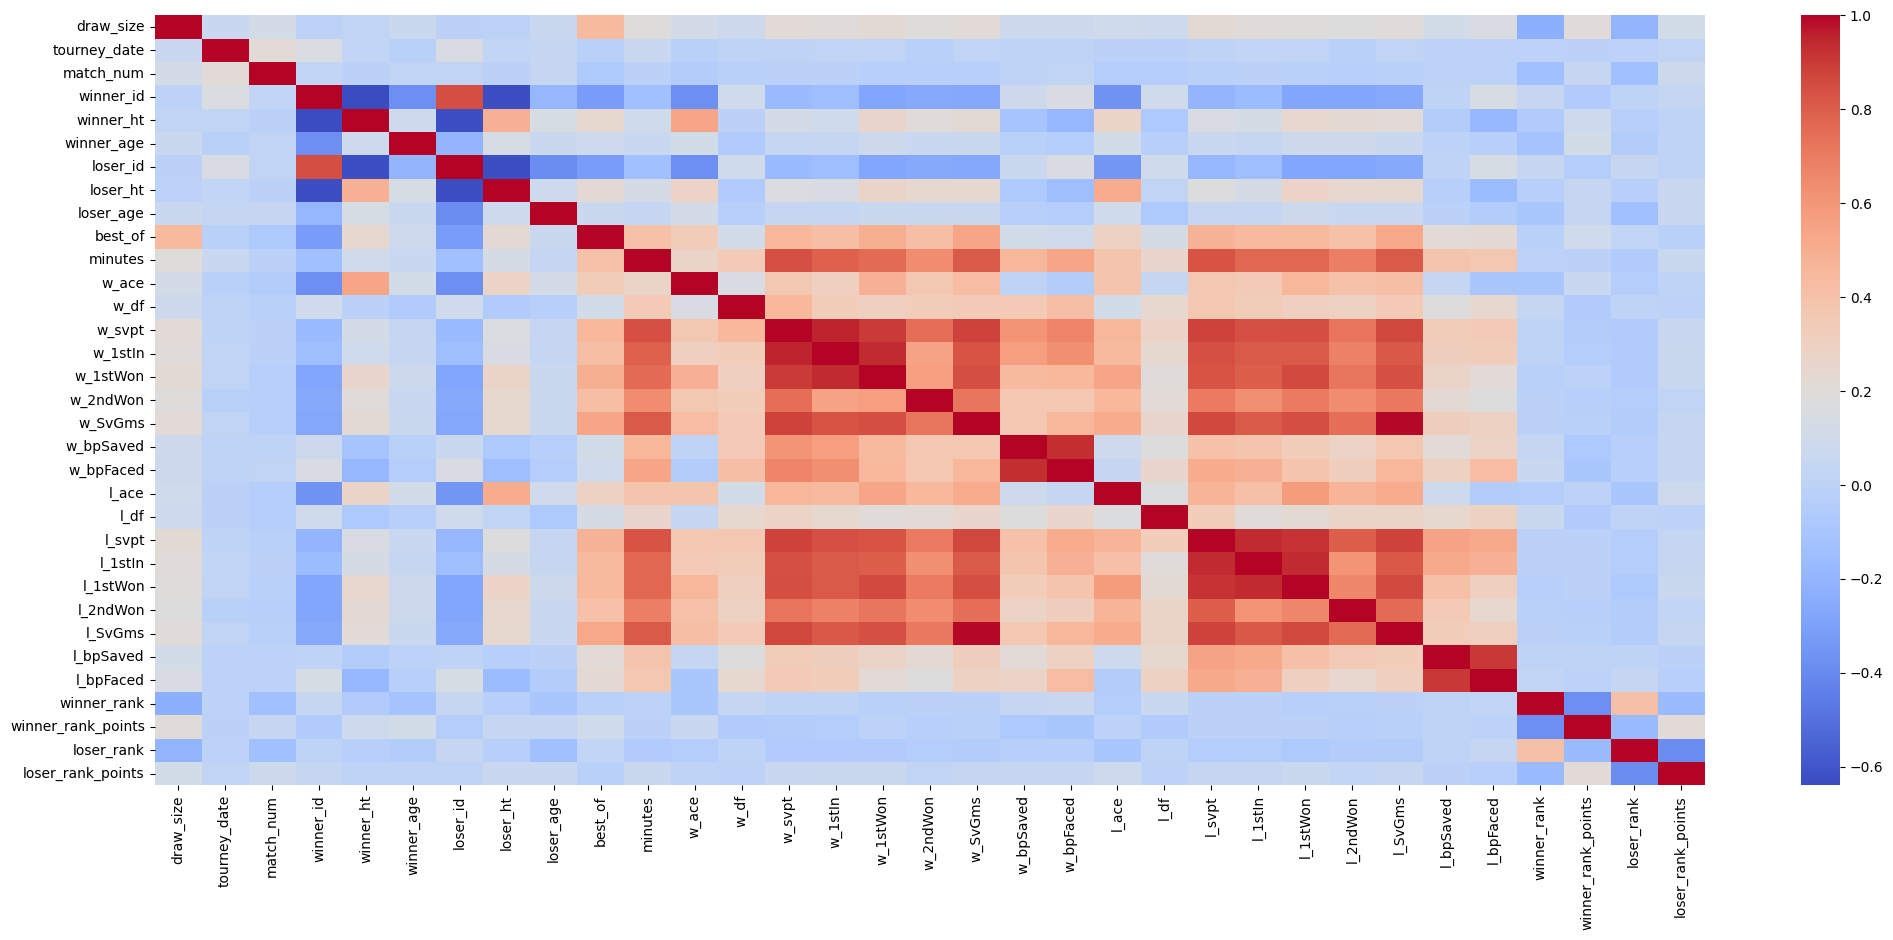

In [187]:
plt.figure(figsize=(25,10))
sns.heatmap(corrmat.round(2), annot=False, cmap='coolwarm')

plt.show()

From this we can see that `w_svpt`, `w_1stIn` and `w_1stWon` as well as `l_svpt`, `l_1stIn` and `l_1stWon` are higly correlated.
> I suggest keeping only one of these for both winner and loser.

### Variable distributions


In [188]:
merged_df['tourney_name'] = merged_df['tourney_name'].replace('Us Open', 'US Open')

#### Tournaments with the highest number of matches
To predict future matches outcome we need to consider what tournaments are our data from. In the graph below we can see that the tournaments with the highest number of matches played are the Grand Slams (US Open, Australian Open, Roland Garros and Wimbledon). These are the most popular tennis tournaments in the world and they are also the ones with the highest viewership.

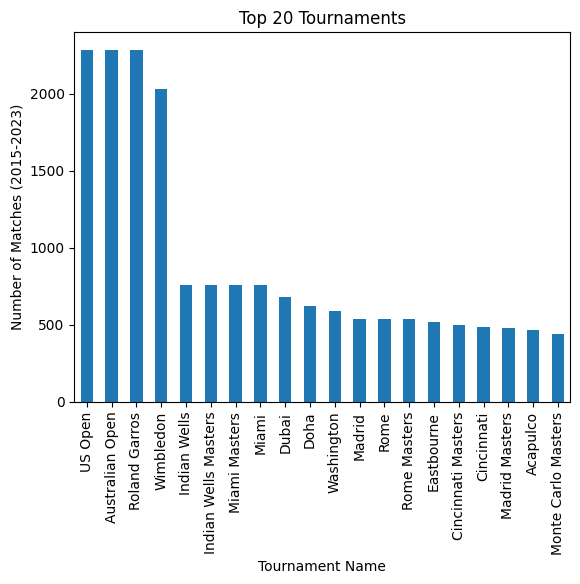

In [189]:
top_tournaments = merged_df['tourney_name'].value_counts().head(20) # check US Open and Us open
# Us Open 2019(M)-2023
# US Open 2015- 2019(F)
# -> consider US Open and Us Open as one (rename)

top_tournaments.plot(kind='bar')
plt.title('Top 20 Tournaments')
plt.xlabel('Tournament Name')
plt.ylabel('Number of Matches (2015-2023)')
plt.show()

#### Entries of players
I want to look into this variable to decide wether to keep it or remove it from the dataframe.
The most entries are `Q` as qualified which would make sense also for the missing values. 

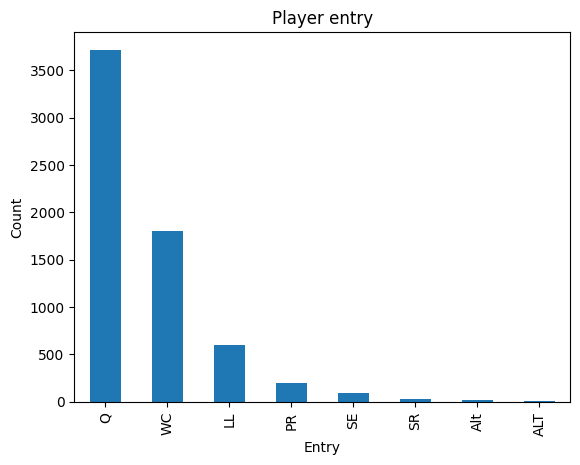

In [190]:
entries = merged_df['winner_entry'].value_counts()
# merged_df['loser_entry'].value_counts()
#vyskusat missing vals nahradit Q
entries.plot(kind='bar')
plt.title('Player entry')
plt.xlabel('Entry')
plt.ylabel('Count')
plt.show()


#### Surface

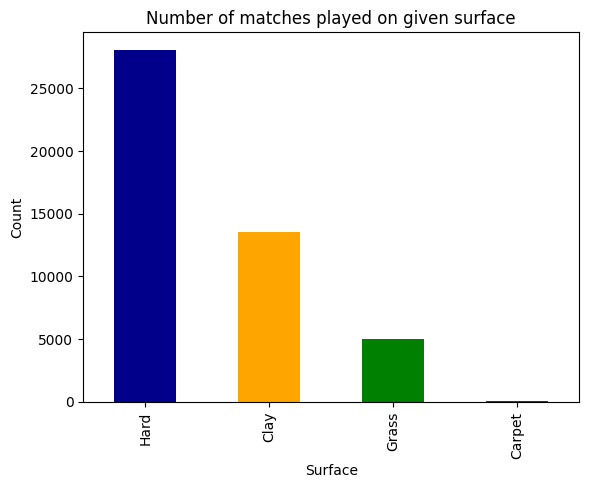

In [191]:
surface = merged_df['surface'].value_counts()
colors = ['darkblue', 'orange', 'green', 'purple']
surface.plot(kind='bar', color=colors)
plt.title('Number of matches played on given surface')
plt.xlabel('Surface')
plt.ylabel('Count')
plt.show()

I would remove the Carpet rows from the dataframe since there is almost none match played on Carpet. (=suggestion for Data Preparation stage)

#### Share of won matches on different surface
Now lets look into the top players for each surface (excluding Carpet)

In [192]:
f_player_surf = df_w.groupby(['winner_id', 'winner_name', 'surface']).size().reset_index(name='wins')
f_player_surf_l = df_w.groupby(['loser_id', 'loser_name', 'surface']).size().reset_index(name='losses')
m_player_surf = df_m.groupby(['winner_id', 'winner_name', 'surface']).size().reset_index(name='wins')
m_player_surf_l = df_m.groupby(['loser_id', 'loser_name', 'surface']).size().reset_index(name='losses')

In [193]:
f_player_surf_l.columns = ['player_id', 'player_name', 'surface', 'losses']
f_player_surf.columns = ['player_id', 'player_name', 'surface', 'wins']
m_player_surf_l.columns = ['player_id', 'player_name', 'surface', 'losses']
m_player_surf.columns = ['player_id', 'player_name', 'surface', 'wins']

In [194]:
f_merged_player_data = pd.merge(f_player_surf, f_player_surf_l, on=['player_id', 'player_name', 'surface'], how='outer')
f_merged_player_data[['wins', 'losses']]= f_merged_player_data[['wins', 'losses']].fillna(0)
f_merged_player_data['wins_minus_losses'] = f_merged_player_data['wins'] - f_merged_player_data['losses']
f_merged_player_data['share'] = f_merged_player_data['wins'] / (f_merged_player_data['wins'] + f_merged_player_data['losses'])

m_merged_player_data = pd.merge(m_player_surf, m_player_surf_l, on=['player_id', 'player_name', 'surface'], how='outer')
m_merged_player_data[['wins', 'losses']]= m_merged_player_data[['wins', 'losses']].fillna(0)
m_merged_player_data['wins_minus_losses'] = m_merged_player_data['wins'] - m_merged_player_data['losses']
m_merged_player_data['share'] = m_merged_player_data['wins'] / (m_merged_player_data['wins'] + m_merged_player_data['losses'])

In [195]:
f_merged_player_data.drop(['wins', 'losses'], axis=1, inplace=True)
m_merged_player_data.drop(['wins', 'losses'], axis=1, inplace=True)

I created a table for both male and female players where I have their names and ids as the index and the surfaces as the columns. The values are then `number of matches the player won` - `number of matches the player lost`. 
Below we can see an example of this table for male players.

In [196]:
tab = m_merged_player_data.pivot_table(values='wins_minus_losses', index=['player_id', 'player_name'], columns='surface', fill_value=0)
tab.head(10)

,surface,Carpet,Clay,Grass,Hard
player_id,player_name,,,,
100644,Alexander Zverev,0,81,15,117
102800,Nenad Zimonjic,0,0,0,-2
103163,Tommy Haas,0,-4,-3,-8
103188,Michael Russell,0,0,0,-1
103285,Radek Stepanek,0,0,-2,-1
103333,Ivo Karlovic,0,-7,10,-1
103401,Jan Hernych,0,0,0,-1
103499,Aqeel Khan,0,-1,3,1
103523,Rohan Bopanna,0,0,1,0


I also created a table of the share. This means that the values in the table are `number of matches won` / `number of all matches played`. We can again see an example of this table for male players below.

In [197]:
share_tab = m_merged_player_data.pivot_table(values='share', index=['player_id', 'player_name'], columns='surface', fill_value=0)
share_tab.head(10)

,surface,Carpet,Clay,Grass,Hard
player_id,player_name,,,,
100644,Alexander Zverev,0.0,0.74,0.65,0.68
102800,Nenad Zimonjic,0.0,0.00,0.00,0.00
103163,Tommy Haas,0.0,0.33,0.36,0.00
103188,Michael Russell,0.0,0.00,0.00,0.00
103285,Radek Stepanek,0.0,0.50,0.33,0.48
103333,Ivo Karlovic,0.0,0.40,0.61,0.50
103401,Jan Hernych,0.0,0.00,0.50,0.00
103499,Aqeel Khan,0.0,0.33,0.67,0.60
103523,Rohan Bopanna,0.0,0.00,1.00,0.00


In [198]:
tabf = f_merged_player_data.pivot_table(values='wins_minus_losses', index=['player_id', 'player_name'], columns='surface', fill_value=0)

In [199]:
share_tabf = f_merged_player_data.pivot_table(values='share', index=['player_id', 'player_name'], columns='surface', fill_value=0)

In [200]:
def plotting_best_players(tableb, tablesh, surface, color, sex):
    sort_tab = tableb.sort_values(by=surface, ascending=False)
    best10_tab = sort_tab.head(10)

    sort_tab_sh = tablesh.sort_values(by=surface, ascending=False)
    best10_tab_sh = sort_tab_sh.head(10)

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.barh(best10_tab.index.get_level_values('player_name'), best10_tab[surface], color=color)
    plt.xlabel('Count')
    plt.ylabel('Player Name')
    plt.title('Top 10 ' + sex + ' Players on ' + surface + ' Surface')

    plt.subplot(1,2,2)
    plt.barh(best10_tab_sh.index.get_level_values('player_name'), best10_tab_sh[surface], color=color)
    plt.xlabel('Win Rate')
    plt.ylabel('Player Name')
    plt.title('Top 10 ' + sex + ' Players on ' + surface + ' Surface')

    plt.tight_layout()
    plt.show()

# def plotting_share_players(table, surface, color, sex):
#     sort_tab = table.sort_values(by=surface, ascending=False)
#     best10_tab = sort_tab.head(10)

#     plt.figure(figsize=(8,4))
    

In the following graphs we show:
1. Top 10 players with the highest number of matches won - matches lost on a given surface
2. Top 10 players with the best win rate for a given surface (this is a bit misleading since some players could have played only one match on the given surface and they won the match so their win rate is 1.0 - I will remove these players in Data Preparation stage)

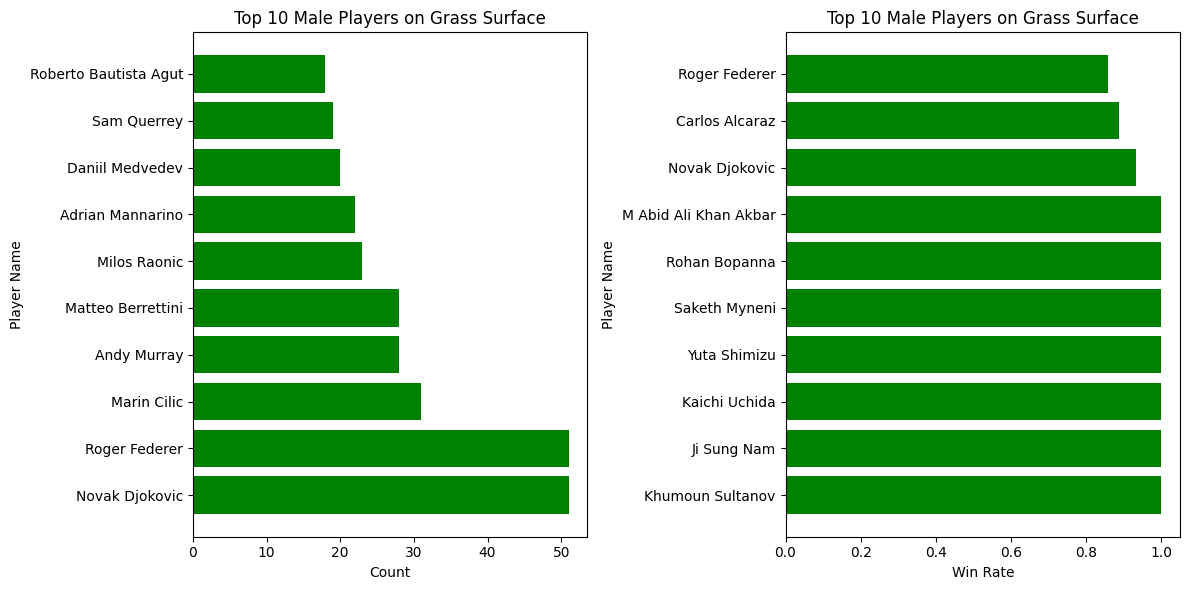

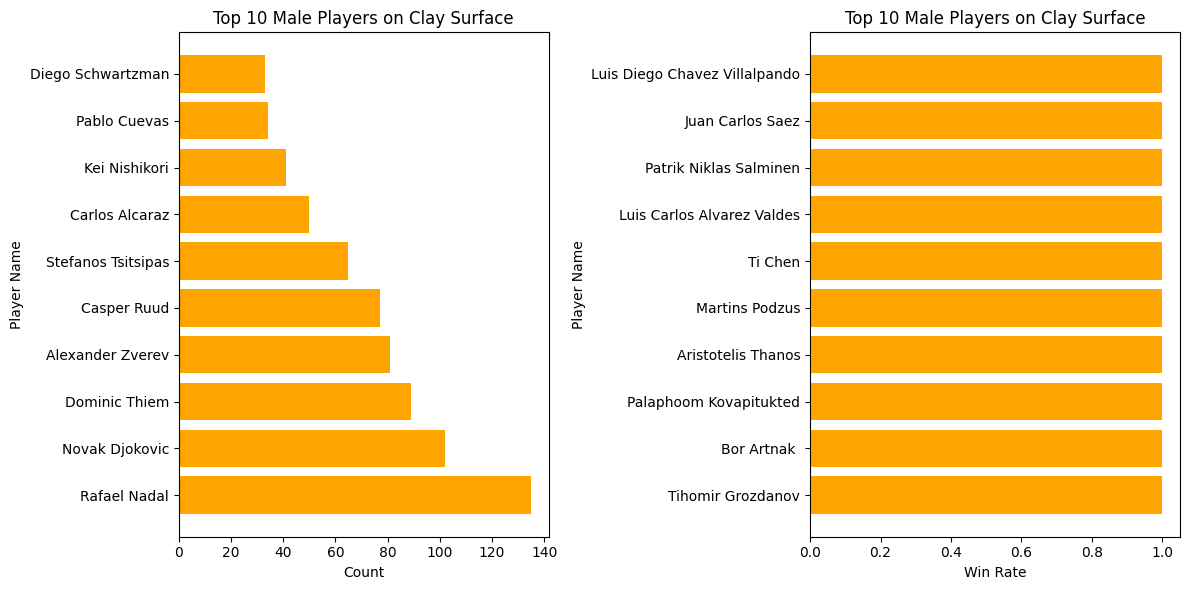

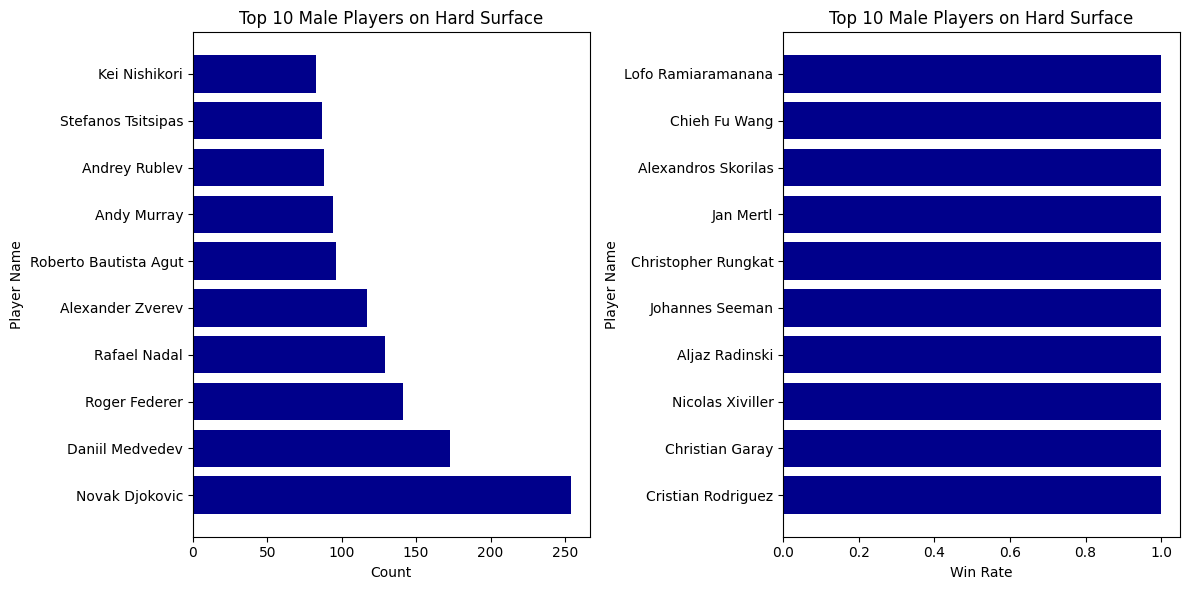

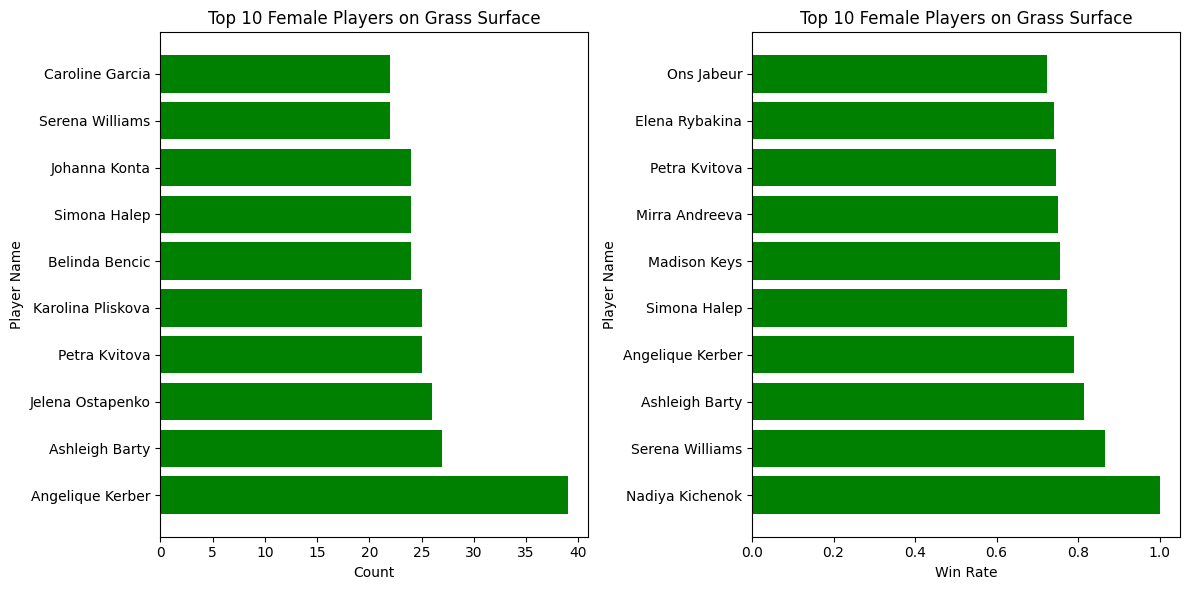

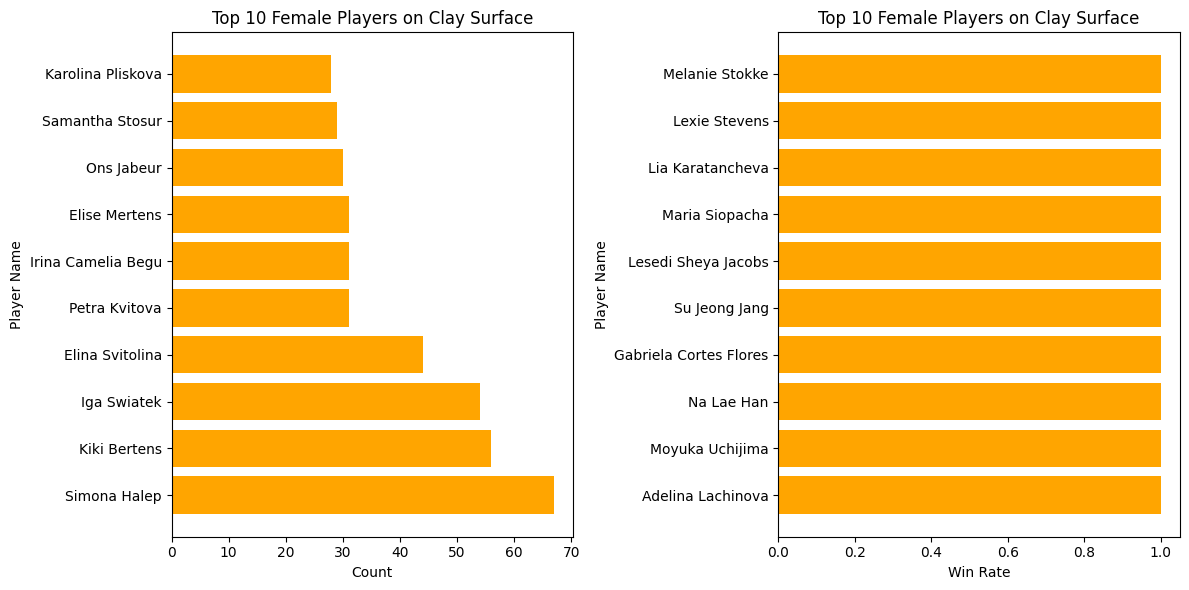

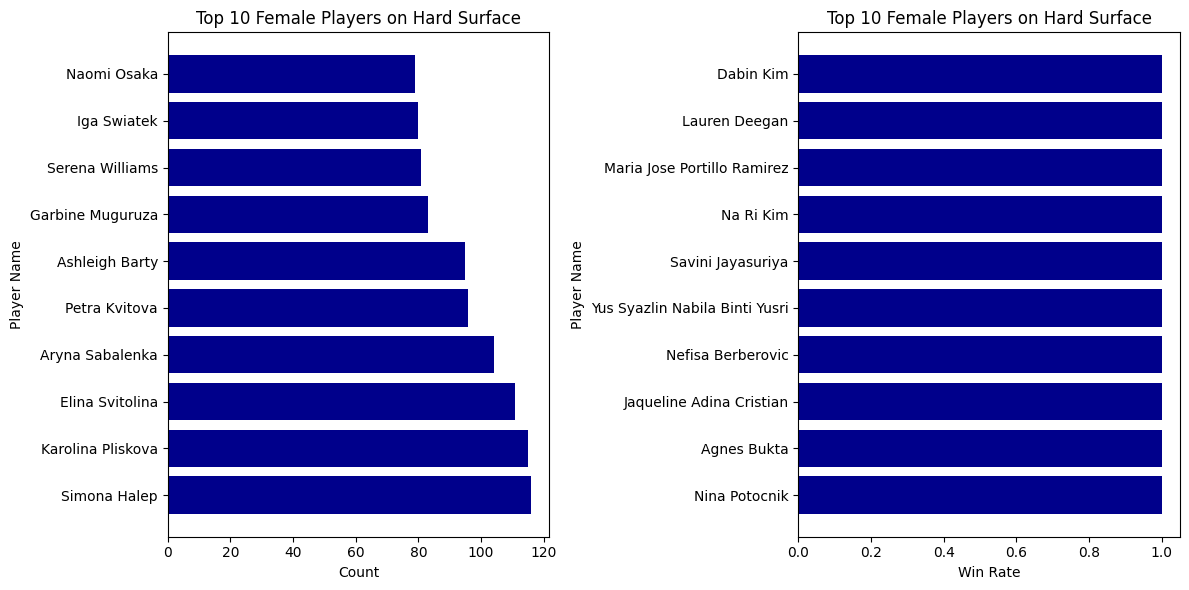

In [201]:

plotting_best_players(tab, share_tab, 'Grass', 'green', 'Male')
#plotting_share_players(share_tab, 'Grass', 'green', 'shares for Male')
plotting_best_players(tab, share_tab, 'Clay', 'orange', 'Male')
# plotting_share_players(share_tab, 'Clay', 'orange', 'shares for Male')
plotting_best_players(tab, share_tab, 'Hard', 'darkblue', 'Male')
# plotting_share_players(share_tab, 'Hard', 'darkblue', 'shares for Male')

plotting_best_players(tabf, share_tabf, 'Grass', 'green', 'Female')
# plotting_share_players(share_tabf, 'Grass', 'green', 'shares for Female')
plotting_best_players(tabf, share_tabf, 'Clay', 'orange', 'Female')
# plotting_share_players(share_tabf, 'Clay', 'orange', 'shares for Female')
plotting_best_players(tabf, share_tabf, 'Hard', 'darkblue', 'Female')
# plotting_share_players(share_tabf, 'Hard', 'darkblue', 'shares for Female')


The best players differ for different surfaces. However the overall best players like Novak Djokovic, Rafael Nadal and Roger Federer occur in every surface same as for women Simona Halep, Petra Kvitova, or Karolina Pliskova.

#### Match duration

I mentioned above that match outcome depends also on the length of the match because some players might suffer from fatigue which lowers their performance. Therefore, I wanted to check the highest and the lowest lengths of the matches we have in our dataset.

Showing the longest matches:

In [202]:
longest_match = merged_df.sort_values('minutes', ascending=False).head(10)
pd.set_option('display.max_columns', 500)

selected_columns = ['tourney_id', 'tourney_name', 'tourney_date', 'match_num', 'minutes']
subset_df = longest_match[selected_columns]


print("The average length of a match is: ", merged_df['minutes'].mean(), " minutes, but we have 13% missing vals -> still need to prepare this for further modelling.")
subset_df

# toto suvisi s data quality ze kolko tam mame toho missing
# Are there missing values in the data? If so, how are they represented, where do they occur, and how common are they?

The average length of a match is:  105.65632311291712  minutes, but we have 13% missing vals -> still need to prepare this for further modelling.


,tourney_id,tourney_name,tourney_date,match_num,minutes
33677,2018-1101,Lugano,20180409,281,2475.0
32705,2018-0804,Charleston,20180402,298,1507.0
3075,2016-M001,Sydney,20160111,294,1146.0
32076,2017-M024,Cincinnati,20170814,293,1094.0
7141,2017-0308,Munich,20170501,297,987.0
10632,2018-540,Wimbledon,20180702,224,396.0
15468,2020-520,Roland Garros,20200928,1139,365.0
35021,2018-W-FC-2018-G2-AM-B-B-M-TTO-BAH-01,Fed Cup G2 RR: TTO vs BAH,20180719,2,361.0
32238,2017-W-FC-2017-G2-AM-B-M-GUA-DOM-01,Fed Cup G2 RR: GUA vs DOM,20170721,2,356.0
9729,2018-M-DC-2018-G1-AO-M-PAK-UZB-01,Davis Cup G1 R2: PAK vs UZB,20180406,1,356.0


Now showing the shortest non-zero long matches:

In [203]:
non_zero_minutes = merged_df[merged_df['minutes'] > 0]

shortest_match = non_zero_minutes.sort_values('minutes', ascending=True).head(10)
pd.set_option('display.max_columns', 500)

selected_columns = ['tourney_id', 'tourney_name', 'tourney_date', 'match_num', 'minutes']
subset_df = shortest_match[selected_columns]


print("The average length of a match is: ", merged_df['minutes'].mean(), " minutes, but we have 13% missing vals -> still need to prepare this for further modelling.")
subset_df

The average length of a match is:  105.65632311291712  minutes, but we have 13% missing vals -> still need to prepare this for further modelling.


,tourney_id,tourney_name,tourney_date,match_num,minutes
44498,2023-2014,Adelaide 2,20230109,290,1.0
41917,2022-2060,Sydney,20220110,292,1.0
43561,2022-1017,Cincinnati,20220815,283,1.0
43564,2022-1017,Cincinnati,20220815,280,1.0
42563,2022-2020,Istanbul,20220418,288,1.0
41879,2022-2030,Adelaide 2,20220110,299,1.0
44012,2022-2025,Ostrava,20221003,289,1.0
43074,2022-710,Eastbourne,20220620,297,1.0
43613,2022-2040,Cleveland,20220822,286,1.0
43041,2022-2017,Bad Homburg,20220620,299,1.0


We can see that this is not a valid value for a match duration... It could have happen that a player scratched the match after one minute or something but we need to think of a way how to treat values like this. There are also many matches with duration of 0 minutes. This could also be the case where a player scratched the match. However, I think that predicting a future match outcome shouldn't take cases like this into account. So I believe it would be the best to remove matches that took less than a certain value. 
- the certain value will be observed by averaging the typically long matches. This means removing ~ matches shorter than 35mins and longer than 6hours (360mins).

#### Number of matches distributed to months through each year

We will explore the distribution of number of matches in different months each year.

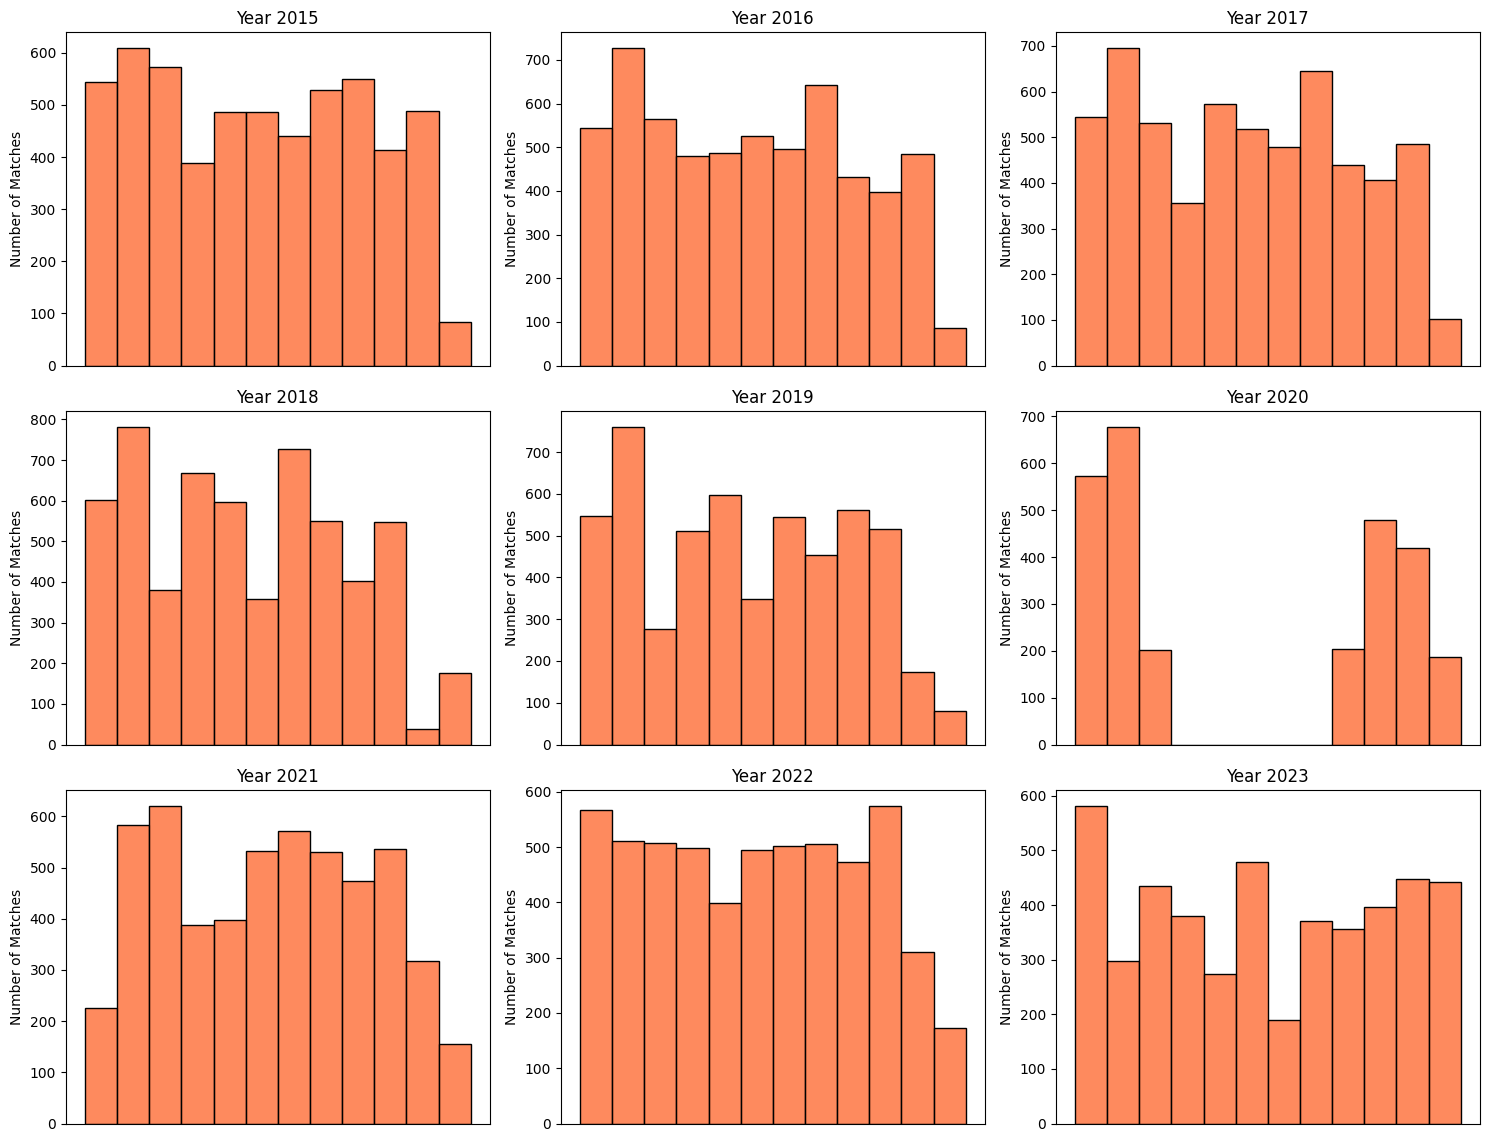

In [204]:
merged_df['tourney_date'] = pd.to_datetime(merged_df['tourney_date'], format='%Y%m%d')

merged_df['year'] = merged_df['tourney_date'].dt.year

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, year in enumerate(range(2015, 2024)):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    matches_for_year = merged_df[merged_df['year'] == year]

    sns.histplot(matches_for_year['tourney_date'], bins=12, color='#FE6328', ax=ax)
    ax.set_title(f'Year {year}')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_ylabel('Number of Matches')
    ax.grid(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

From the graph we can see higher peaks during the months where big Grand Slam tournaments take place. The distribution is very similar in years from 2015 till 2019. The covid pandemic started in 2020 and in that year we can see a gap from march till september where not a single match took place since the pandemic started and our lives stopped for a moment. The distribution of matches during the year changed a bit since covid which is an interesting observation.

I also wanted to see different patterns of distribution between WTA and ATP tournaments (WTA in red, ATP in blue).

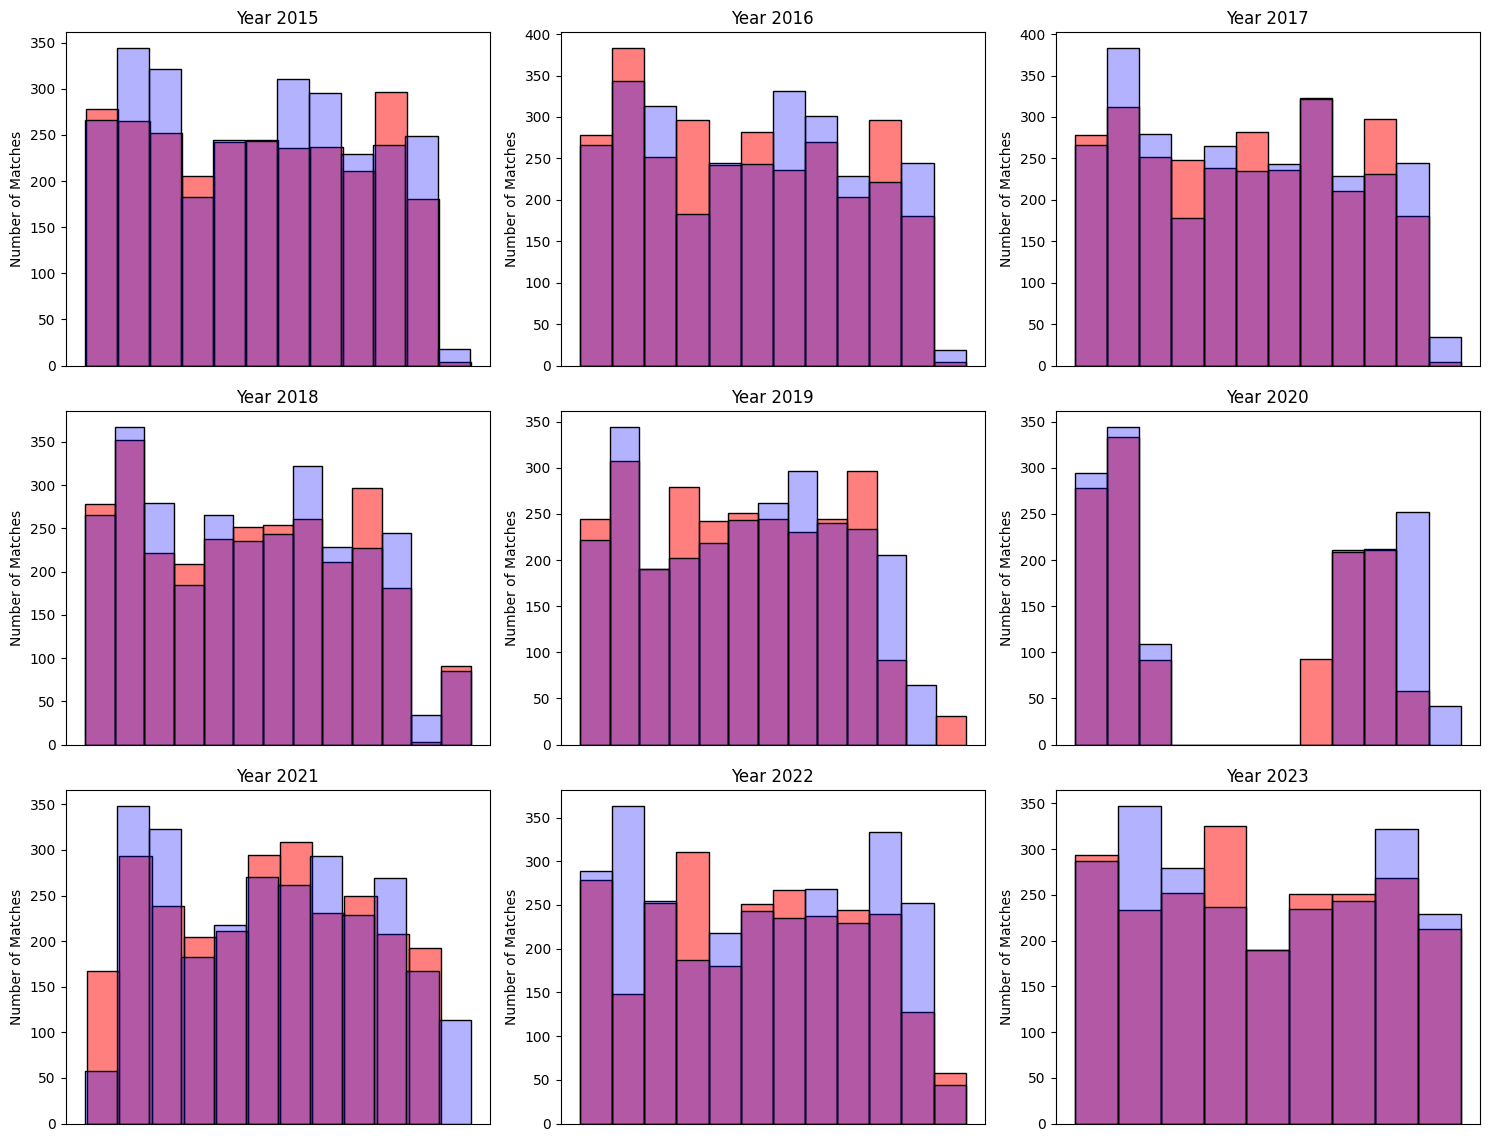

In [205]:
df_w['tourney_date'] = pd.to_datetime(df_w['tourney_date'], format='%Y%m%d')
df_w['year'] = df_w['tourney_date'].dt.year

df_m['tourney_date'] = pd.to_datetime(df_m['tourney_date'], format='%Y%m%d')
df_m['year'] = df_m['tourney_date'].dt.year

fig, axes = plt.subplots(3, 3, figsize=(15, 12), )

for i, year in enumerate(range(2015, 2024)):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    matches_for_year_f = df_w[df_w['year'] == year]
    matches_for_year_m = df_m[df_m['year'] == year]

    bin_edges = pd.date_range(start=matches_for_year_m['tourney_date'].min(), end=matches_for_year_m['tourney_date'].max(), freq='M')

    sns.histplot(x=matches_for_year_f['tourney_date'], bins=bin_edges, color='red', alpha=0.5, ax=ax, label='Female (WTA)', binwidth=28)
    sns.histplot(x=matches_for_year_m['tourney_date'], bins=bin_edges, color='blue', alpha=0.3, ax=ax, label='Male (ATP)', binwidth=28)
    ax.set_title(f'Year {year}')
    ax.set_xlabel('')
    ax.set_xticks([])
    ax.set_ylabel('Number of Matches')
    ax.grid(False)
   
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#### Correlation of ranking before the match and the match outcome


I want to check wether there is correlation between the rank of players and the outcome of the match. For this task I will create a new binary variable `higher_ranked_winner` in my dataset. This will be True if the difference between `loser_rank` - `winner_rank` is greater than 0 and False otherwise. The ranking in tennis is ordered from highest ranked player = rank 1 and then other players have a greater number. Thats why we want the value to be positive.

In [206]:
merged_df['rank_difference'] = merged_df['loser_rank'] - merged_df['winner_rank']
merged_df['higher_ranked_winner'] = merged_df['rank_difference'] > 0
correlation_matrix = merged_df[['higher_ranked_winner', 'winner_rank', 'loser_rank']].corr()
#print(correlation_matrix)

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


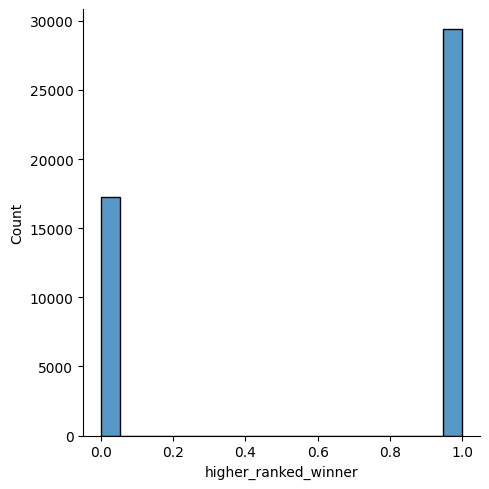

In [207]:
sns.displot(merged_df['higher_ranked_winner'])

In [208]:
print(merged_df['higher_ranked_winner'].value_counts())

True     29385
False    17273
Name: higher_ranked_winner, dtype: int64


From the graph and from the `value_counts()` of this variable I assume there is correlation. However this assumption is not enough so I will use statistical t test to check it.
- **The null hypothesis is**: There is no correlation between the rank of the player before the match and the match outcome. (there is no significant difference between the number of matches where the winner had a higher rank before the match and the matches where the loser had a higher rank before the match.)
- **The alternate hypothesis**: There is correlation between the rank of the player before the match and the match outcome. (there is a significant difference between the number of matches where the winner had a higher rank before the match and the matches where the loser had a higher rank before the match.)

I'm going to use `ttest_ind` from `scipy.stats` to perform an independent two-sample t-test with unequal variances

In [209]:
merged_df['rank_difference'].fillna(merged_df['rank_difference'].mean(), inplace=True)

In [210]:
import numpy as np
print("Number of missing values in 'rank_difference':", merged_df['rank_difference'].isnull().sum())
print("Number of infinite values in 'rank_difference':", np.isinf(merged_df['rank_difference']).sum())


Number of missing values in 'rank_difference': 0
Number of infinite values in 'rank_difference': 0


I added mean of the rank of players to the rows where there was a missing value since it is a significant variable for the match outcome.

In [211]:
from scipy.stats import ttest_ind

winner_higher_rank = merged_df[merged_df['higher_ranked_winner'] == True]['rank_difference']
loser_higher_rank = merged_df[merged_df['higher_ranked_winner'] == False]['rank_difference']

t_statistic, p_value = ttest_ind(winner_higher_rank, loser_higher_rank, equal_var=False)
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 132.17056679749453
P-value: 0.0


**T test results**

T-statistic: The magnitude of the t-statistic indicates how many standard deviations the means of the two groups are apart. A larger absolute t-statistic suggests a more significant difference.

P-value: The very low p-value (approaching zero) indicates that the observed difference in `rank_difference` is highly unlikely to occur by random chance, supporting the rejection of the null hypothesis.

In conclusion, based on the statistical test, there is strong evidence to suggest that the rank difference between the winner and loser is significantly different between matches where the winner has a higher rank and matches where the loser has a higher rank.

### Chyba zhrnutie kratke


#### Favourite oponents

In [212]:
# Assuming 'winner_id' and 'loser_id' are player IDs and 'score' indicates match outcome

# Create a DataFrame with player pairs and their respective wins and total matches
player_pairs = merged_df.groupby(['winner_name', 'loser_name']).size().reset_index(name='total_matches')
player_wins = merged_df.groupby(['winner_name', 'loser_name']).size().reset_index(name='player1_wins')

# Merge the DataFrames
player_scores = pd.merge(player_pairs, player_wins, on=['winner_name', 'loser_name'], how='left')

# Calculate win ratio
player_scores['win_ratio'] = player_scores['player1_wins'] / player_scores['total_matches']

# Set a threshold for unbalance (e.g., 0.8 means 80% win ratio)
threshold = 0.75

# Filter for favorite opponents based on the threshold
favorite_opponents = player_scores[player_scores['win_ratio'] > threshold]

favorite_opponents = favorite_opponents[player_scores['total_matches'] > 8]

# Display the results
favorite_opponents


,winner_name,loser_name,total_matches,player1_wins,win_ratio
8076,Daniil Medvedev,Alexander Zverev,9,9,1.0
18070,Karolina Pliskova,Garbine Muguruza,9,9,1.0
21157,Madison Keys,Daria Kasatkina,9,9,1.0
25225,Novak Djokovic,Andy Murray,11,11,1.0
25243,Novak Djokovic,Daniil Medvedev,10,10,1.0
25265,Novak Djokovic,Gael Monfils,9,9,1.0
25297,Novak Djokovic,Karen Khachanov,9,9,1.0
25298,Novak Djokovic,Kei Nishikori,16,16,1.0
25311,Novak Djokovic,Marin Cilic,9,9,1.0
25338,Novak Djokovic,Rafael Nadal,11,11,1.0


## Stage III: Data Preparation

In this stage we're going to deal with missing values and some data transormation.

- first, I want to replace missing values in winner_entry and loser_entry with Q which as stated in previous stage is the most abundant value
- second, I want to replace missing vals in loser_seed with some high number, ideally with the highest number of all rankes that are present in my dataset
- third, I want to replace missing vals in winner_seed with the average of the present values for winner_entry variable
- fourth, I want to calculate the average length of one game and then replace missing vals in minutes by adding up the average based on how many games were played - there should always be information about the score

In [213]:
# replace missing vals in winner_entry and loser_entry variables with Q as qualified
merged_df['winner_entry'].fillna('Q', inplace=True)
merged_df['loser_entry'].fillna('Q', inplace=True)

In [214]:
missing_values_table(merged_df)

,Missing Values,% of Missing vals
loser_seed,35386,75.8
winner_seed,27277,58.5
minutes,6053,13.0
loser_ht,3555,7.6
l_SvGms,2648,5.7
w_SvGms,2648,5.7
w_df,2336,5.0
l_df,2336,5.0
l_ace,2331,5.0
w_bpSaved,2331,5.0


As we can see in the table, we got rid of missing values in winner_entry and loser_entry.

In [215]:
loser_seed = merged_df['loser_seed']

In [216]:
loser_seed.value_counts().sort_values()

33       2
19       8
23       8
LL       8
30       8
      ... 
4.0    864
6.0    879
7.0    894
5.0    896
8.0    914
Name: loser_seed, Length: 69, dtype: int64

I found out that 33 was the lowest rank for loser of any match in the dataset. It would make sense to replace missing values with a number higher than this but not very high - I suggest 35. I also found out that there is value "LL" in this column - but this should be in column entry not seed. "LL" however, means lucky loser, who is a player that wasn't initially qualified for the tournament but ended up playing likely because some other player withdrawed. We could replace "LL" here with 35 as well. 

I also found some Qs and WCs in this column - I'm replacing WC with 35 since it's very similar to LL and replacing Q with 17 as the median.

In [217]:
# replace missing value in loser_seed with 35
merged_df['loser_seed'].fillna(35, inplace=True)

In [218]:
# replace LL in 'loser_seed with 35'
merged_df['loser_seed'].replace('LL', '35', inplace=True)

In [219]:
merged_df['loser_seed'].replace('Q', '17', inplace=True)

In [220]:
merged_df['loser_seed'].replace('WC', '35', inplace=True)

In [221]:
merged_df['loser_seed'] = merged_df['loser_seed'].astype(int)

We ended up with these values in the 'loser_seed' column - I only show the 10 most common seeds for the loser

In [222]:
merged_df['loser_seed'].value_counts().sort_values(ascending=False).head(10)

35    35414
8       989
5       964
7       962
6       949
4       937
3       919
2       859
1       741
9       354
Name: loser_seed, dtype: int64

In [223]:
winner_seed = merged_df['winner_seed'].dropna()

In [224]:
winner_seed.replace('Q', '17', inplace=True)

In [225]:
winner_seed.replace('WC', '35', inplace=True)

The mean from all the values present in `winner_seed`, while again replacing 'Q' with 17 and 'WC' with 35, is:

In [226]:
winner_seed.astype(int).mean()

7.994840307517672

We will replace the missing values here with 8. Below are the 10 most common seeds for a winner

In [227]:
merged_df['winner_seed'].fillna(8, inplace=True)
merged_df['winner_seed'].replace('Q', '17', inplace=True)
merged_df['winner_seed'].replace('WC', '35', inplace=True)
merged_df['winner_seed'] = merged_df['winner_seed'].astype(int)
merged_df['winner_seed'].value_counts().sort_values(ascending=False).head(10)

8     28716
1      2289
2      1963
3      1755
4      1613
5      1596
6      1502
7      1441
9       577
10      469
Name: winner_seed, dtype: int64

The next column we need to edit are minutes. I mentioned that I want to calculate the mean length of a game and then add up minutes based on games played in one match.

In [228]:
merged_df

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year,rank_difference,higher_ranked_winner
0,2015-339,Brisbane,Hard,28,A,2015-01-04,1,105357,8,WC,John Millman,R,183.0,AUS,25.5,105733,35,Q,Rhyne Williams,R,185.0,USA,23.7,6-3 6-1,3,R32,65.0,6.0,2.0,44.0,24.0,19.0,14.0,8.0,1.0,1.0,3.0,4.0,50.0,31.0,20.0,5.0,8.0,1.0,5.0,153.0,328.0,220.0,221.0,2015,67.0,True
1,2015-339,Brisbane,Hard,28,A,2015-01-04,2,103813,8,Q,Jarkko Nieminen,L,185.0,FIN,33.4,106045,35,Q,Denis Kudla,R,180.0,USA,22.3,4-6 6-1 6-4,3,R32,104.0,4.0,0.0,92.0,59.0,39.0,17.0,14.0,4.0,7.0,6.0,1.0,83.0,50.0,26.0,19.0,13.0,3.0,8.0,73.0,689.0,123.0,440.0,2015,50.0,True
2,2015-339,Brisbane,Hard,28,A,2015-01-04,3,105902,8,WC,James Duckworth,R,183.0,AUS,22.9,104468,6,Q,Gilles Simon,R,183.0,FRA,30.0,6-2 6-2,3,R32,68.0,4.0,0.0,45.0,27.0,20.0,11.0,8.0,2.0,3.0,2.0,1.0,56.0,37.0,22.0,5.0,8.0,10.0,15.0,125.0,430.0,21.0,1730.0,2015,-104.0,False
3,2015-339,Brisbane,Hard,28,A,2015-01-04,4,104871,8,Q,Jeremy Chardy,R,188.0,FRA,27.8,104979,35,Q,Andrey Golubev,R,185.0,KAZ,27.4,6-4 6-4,3,R32,69.0,7.0,1.0,53.0,39.0,31.0,11.0,10.0,0.0,0.0,9.0,2.0,57.0,38.0,30.0,8.0,10.0,1.0,3.0,31.0,1195.0,72.0,691.0,2015,41.0,True
4,2015-339,Brisbane,Hard,28,A,2015-01-04,5,105373,8,Q,Martin Klizan,L,190.0,SVK,25.4,103781,35,Q,Jurgen Melzer,L,183.0,AUT,33.6,6-7(5) 7-6(6) 6-1,3,R32,144.0,9.0,4.0,130.0,79.0,55.0,27.0,16.0,6.0,8.0,4.0,4.0,95.0,62.0,40.0,19.0,15.0,4.0,8.0,34.0,1094.0,110.0,505.0,2015,76.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46653,2023-W-FC-2023-QLS-M-SVK-ITA-01,BJK Cup QLS R1: SVK vs ITA,Hard,4,D,2023-04-14,3,203533,8,Q,Anna Karolina Schmiedlova,R,176.0,SVK,28.5,211148,35,Q,Jasmine Paolini,R,160.0,ITA,27.2,6-1 4-6 6-4,3,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0,681.0,66.0,841.0,2023,-30.0,False
46654,2023-W-FC-2023-QLS-M-SVK-ITA-01,BJK Cup QLS R1: SVK vs ITA,Hard,4,D,2023-04-14,4,214149,8,Q,Viktoria Kuzmova,R,NaN,SVK,24.9,220714,35,Q,Elisabetta Cocciaretto,R,NaN,ITA,22.2,6-3 7-6(2),3,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.0,522.0,51.0,1076.0,2023,-76.0,False
46655,2023-W-FC-2023-QLS-M-USA-AUT-01,BJK Cup QLS R1: USA vs AUT,Hard,4,D,2023-04-14,1,221103,8,Q,Cori Gauff,R,175.0,USA,19.0,211814,35,Q,Julia Grabher,R,170.0,AUT,26.7,6-1 6-3,3,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4346.0,78.0,756.0,2023,72.0,True
46656,2023-W-FC-2023-QLS-M-USA-AUT-01,BJK Cup QLS R1: USA vs AUT,Hard,4,D,2023-04-14,2,202468,8,Q,Jessica Pegula,R,170.0,USA,29.1,221257,35,Q,Sinja Kraus,R,NaN,AUT,20.9,6-0 7-5,3,RR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5735.0,153.0,434.0,2023,150.0,True


In [229]:
import re
# Assuming 'score' is the name of the column
# Extract the number of games played from the 'score' column, excluding tiebreak scores in parentheses
def extract_num_games(score):
    game_scores = re.findall(r'\d+-\d+', score)
    total_games = sum(map(lambda x: sum(map(int, x.split('-'))), game_scores))
    return total_games

# merged_df['num_games'] = merged_df['score'].apply(extract_num_games)

# Calculate the average length of a game
# average_length_of_one_game = (merged_df['minutes'] / merged_df['num_games']).mean()

While trying to find the average length of one game, I encountered a problem. The problem is that some matches do not have a score - these are the ones, where the score is "W/O". In tennis, "W/O" stands for "Walkover." A walkover occurs when one player or team wins a match because their opponent(s) withdraw before the match begins or during the match due to injury, illness, or other reasons. It will be best to remove these rows, since it doesn't provide us with any information about the match metrics relationship with the match outcome. There is no use to have this in out dataset. Below is an example of a match like this.

In [230]:
# Assuming 'score' is the name of the column
merged_df = merged_df[merged_df['score'] != "W/O"]

In [231]:
merged_df['num_games'] = merged_df['score'].apply(extract_num_games)

/tmp/ipykernel_702/691061121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['num_games'] = merged_df['score'].apply(extract_num_games)


In [232]:
merged_df = merged_df[merged_df['num_games'] != 0]

In [233]:
average_length_of_one_game = (merged_df['minutes'] / merged_df['num_games']).mean()

The average length of one game is:

In [234]:
average_length_of_one_game

4.461090854097112

In [235]:
merged_df['minutes'] = merged_df['minutes'].fillna(merged_df['num_games'] * average_length_of_one_game)

In [236]:
merged_df = merged_df[merged_df['minutes'] != 0]

We filled the missing values in minutes by multiplying `merged_df['num_games'] * average_length_of_one_game`

We further want to drop some columns that won't be necessary  for modeling.
These are: `match_num`, `tourney_id`, `tourney_name`, `winner_name`, `loser_name` (we are only going to keep their id's), `winner_ioc`, `loser_ioc` and `round`.

We also need to drop some columns that are connected with the winner of the match.
These are: `score`, `higher_ranked_winner`, `num_games`.

In [237]:
columns_to_drop = ['match_num', 'tourney_id', 'tourney_name', 'winner_name', 'loser_name',
                   'winner_ioc', 'loser_ioc', 'round', 'score', 'higher_ranked_winner', 'num_games']

merged_df.drop(columns=columns_to_drop, inplace=True)

Further I want to make the `tourney_date` more helpful for the machine learning model - I will convert it to a numerical value. By doing this we will have the time included in our model and if some player gtes better as the time passes by it will be there.

In [238]:
merged_df['tourney_date'] = merged_df['tourney_date'].dt.date.astype('category')
merged_df['tourney_date'] = merged_df['tourney_date'].cat.codes

#### Feature engineering and building the model
After having all columns prepared I want to add target and preprocess some of them

In [240]:
import numpy as np

np.random.seed(42)
indexes = np.sort(np.random.choice(merged_df.shape[0], merged_df.shape[0]//2, replace=False))

In [241]:
indexes

array([    0,     1,     4, ..., 46345, 46348, 46350])


Now I assume our data is cleaned and prepared for modelling
- maybe we should drop some columns we added during analysis and preparation

In [242]:
merged_df.shape[0]

46352

In [243]:
new_df = merged_df
columns = merged_df.columns.values

In [244]:
col = np.r_[np.arange(0, 4), np.arange(10, 16), np.arange(4, 10), np.arange(16, 18), np.arange(27, 36), np.arange(18, 27),  np.arange(38, 40), np.arange(36, 38), np.arange(40, 42)] 
merged_df.iloc[indexes] = merged_df[columns[col]].iloc[indexes]

In [245]:
target = np.ones(merged_df.shape[0])
target[indexes] = 0

In [246]:
np.sum(target)

23176.0

In [247]:
merged_df.shape[0]

46352

In [248]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [249]:
missing_values_table(merged_df)

,Missing Values,% of Missing vals
winner_ht,2876,6.2
loser_ht,2796,6.0
w_SvGms,2422,5.2
l_SvGms,2422,5.2
l_df,2108,4.5
w_df,2108,4.5
w_bpFaced,2103,4.5
l_1stWon,2103,4.5
l_1stIn,2103,4.5
l_svpt,2103,4.5


In [250]:
merged_df.to_csv('model_version.csv')

In [251]:
columns_with_missing_values = ['winner_ht', 'loser_ht', 'w_SvGms', 'l_SvGms', 'l_df', 'w_df', 'w_bpFaced', 'l_1stWon', 
                               'l_1stIn', 'l_svpt', 'l_ace', 'w_bpSaved', 'w_1stWon', 'w_2ndWon', 'w_1stIn', 'w_svpt', 'w_ace', 'l_bpSaved', 
                               'l_bpFaced', 'l_2ndWon', 'loser_rank', 'loser_rank_points', 'winner_rank', 'winner_rank_points',
                               'winner_age', 'loser_age']

for column in columns_with_missing_values:
    imputer = SimpleImputer(strategy='mean')
    merged_df[column] = imputer.fit_transform(merged_df[[column]])

In [253]:
one_hot_cols = ['winner_entry', 'loser_entry', 'tourney_level', 'surface', 'winner_hand', 'loser_hand']
scale_cols = ['winner_age', 'loser_age', 'winner_ht', 'loser_ht', 'minutes', 'w_ace', 'l_ace', 'w_df', 'l_df', 'w_svpt', 'l_svpt', 'w_1stIn', 'l_1stIn', 
              'w_1stWon', 'l_1stWon', 'w_2ndWon', 'l_2ndWon', 'w_SvGms', 'l_SvGms', 'w_bpSaved', 'l_bpSaved', 'w_bpFaced', 'l_bpFaced']

preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),
        ('scaler', StandardScaler(), scale_cols),
        # ('imputer', SimpleImputer(), scale_cols)
    ],
    remainder='passthrough'  # Include the columns not specified in transformers
)



pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000))
])

X_train, X_test, y_train, y_test = train_test_split(merged_df, target, test_size=0.1, random_state=38)

# model = LogisticRegression()
pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
confusion_mat = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_mat)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.905090595340811
Confusion Matrix:
[[2103  224]
 [ 216 2093]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91      2327
         1.0       0.90      0.91      0.90      2309

    accuracy                           0.91      4636
   macro avg       0.91      0.91      0.91      4636
weighted avg       0.91      0.91      0.91      4636



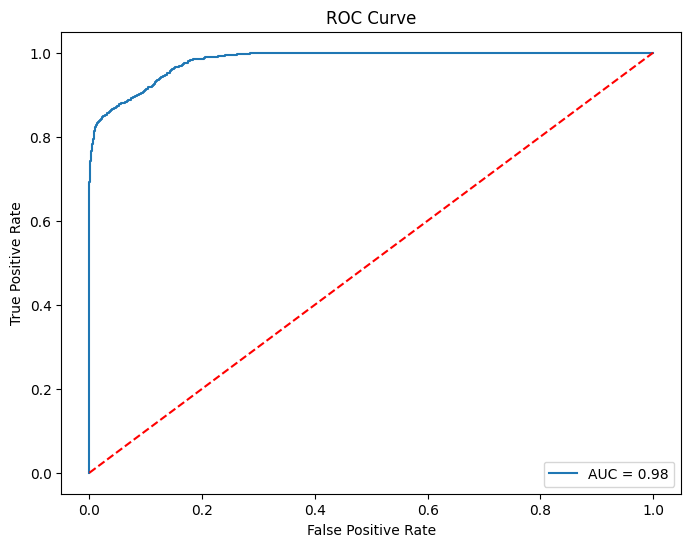

In [254]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities
probs = pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, probs):.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [258]:
# Assuming your model is fitted and named 'pipeline'
if hasattr(pipeline.named_steps['classifier'], 'coef_'):
    coefficients = pipeline.named_steps['classifier'].coef_
    intercept = pipeline.named_steps['classifier'].intercept_

    print("Coefficients:")
    print(coefficients)
    print("\nIntercept:")
    print(intercept)


Coefficients:
[[ 1.65214351e-06  2.49787730e-06 -6.03492558e-05  3.07263070e-05
   2.96257427e-05 -5.81251125e-07  9.45043465e-06  1.15250853e-06
  -1.41566520e-05  3.36113955e-06  2.27332212e-06  7.49650357e-05
  -3.15306890e-05 -4.61541918e-05 -1.00395081e-06 -7.84389080e-07
  -1.10842197e-06  2.31880688e-05 -3.10982272e-07  4.69644971e-05
   7.60492644e-05  2.44952907e-05 -9.41144167e-05 -4.07624501e-06
  -7.19333405e-05  7.94376029e-06 -8.18804226e-06 -2.14672086e-06
  -1.15540825e-04 -1.83552715e-05  1.36060672e-04 -4.55592207e-05
   1.89106478e-04 -1.34171040e-04 -9.35836277e-06  9.55736227e-05
  -2.10689224e-04  1.02062564e-04  1.30708917e-05 -3.41365462e-04
   5.37304994e-04  5.86296797e-04 -3.44492335e-04 -5.07126443e-05
   3.61830125e-03 -3.21674556e-03 -3.47136344e-03  3.71755606e-03
  -7.71729886e-04  9.59182181e-04  1.40025201e-05  1.60371769e-04
   4.17878268e-03 -3.93736316e-03  3.54897298e-03 -3.52529624e-03
   6.78455873e-04 -5.95478691e-04 -3.99456147e-03  4.41470294e

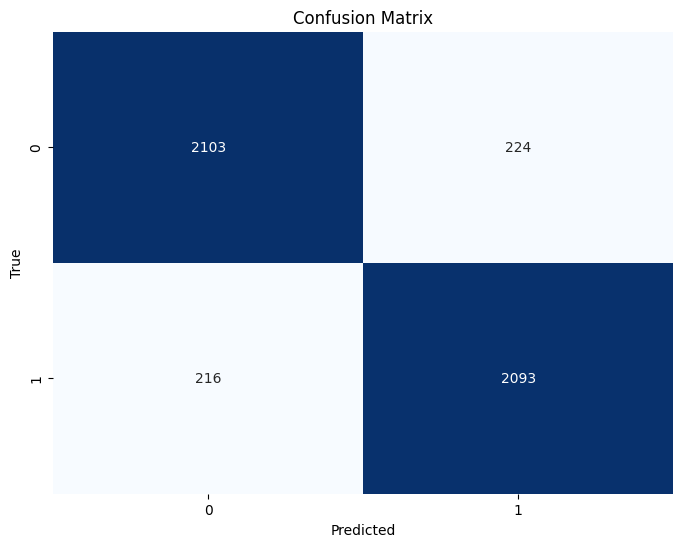

In [256]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [261]:
pipeline.coef_()

AttributeError: 'Pipeline' object has no attribute 'coef_'